In [1]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import wfdb
import seaborn as sns
import os
import requests

from sklearn.svm import SVC,SVR

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

from emg_processor import EMGProcessor
from emg_feature_extractor import EMGFeatureExtractor
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Read Data and Label

In [2]:
import wfdb

# Path to the recording (without file extension)
file_path = "eeg_recording"
# Read the record and metadata
record = wfdb.rdrecord(file_path)

# Access the signals and metadata
signals = record.p_signal  # Processed (physical) signals
sampling_rate = record.fs  # Sampling frequency
signal_names = record.sig_name  # Channel names
units = record.units  # Units for each signal

# Print details
print("Sampling Rate:", sampling_rate)
print("Signal Names:", signal_names)
print("Units:", units)
print("Signals Shape:", signals.shape)

# Example: Access first 10 samples of each signal
print("First 10 Samples of Signals:")
print(signals[:10, :])  # Rows are samples, columns are channels


Sampling Rate: 250
Signal Names: ['O1', 'O2', 'T3', 'T4']
Units: ['mV', 'mV', 'mV', 'mV']
Signals Shape: (49782, 4)
First 10 Samples of Signals:
[[131.73896916 152.25825714 226.1084418  117.25038901]
 [119.2389573  139.75806023 213.60807914 129.74940899]
 [129.41084084 151.14490979 224.72913371 115.83897798]
 [126.10591278 149.88273935 223.1912052  113.94275301]
 [126.08812044 149.40141913 222.46017191 113.85095392]
 [128.93311638 149.6114669  222.41036357 115.53345913]
 [130.09317726 149.44663121 221.92377432 116.30944832]
 [127.89137459 148.4802231  220.68163077 115.09454473]
 [124.36849031 147.09937096 219.11458352 112.74793046]
 [124.49303673 146.71601024 218.53067644 112.88276038]]


In [3]:
labels_path = "eeg_recording_label"
labels_record = wfdb.rdrecord(labels_path)
# Access the signals and metadata
labels = labels_record.p_signal  # Processed (physical) signals
labels_sampling_rate = labels_record.fs  # Sampling frequency
labels_signal_names = labels_record.sig_name  # Channel names
labels_units = labels_record.units  # Units for each signal

# Print details
print("Sampling Rate:", labels_sampling_rate)
print("Signal Names:", labels_signal_names)
print("Units:", labels_units)
print("Signals Shape:", labels.shape)

# Example: Access first 10 samples of each signal
print("First 10 Samples of Signals:")
print(labels[:10, :])  # Rows are samples, columns are channels

Sampling Rate: 250
Signal Names: ['Frequency']
Units: ['Hz']
Signals Shape: (49782, 1)
First 10 Samples of Signals:
[[1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]]


In [4]:
# Ensure labels is a valid iterable (e.g., a list or numpy array)
if labels is None or len(labels) == 0:
    print("The labels array is empty or not defined.")
else:
    # Create a dictionary to group elements in labels
    labels_dict = {}

    # Iterate over the labels array and group by unique label values
    for i, label in enumerate(labels):
        # Convert the label to a tuple to ensure it's hashable
        hashable_label = tuple(label) if isinstance(label, np.ndarray) else label
        # Check if the label is already a key in the dictionary
        if hashable_label not in labels_dict:
            labels_dict[hashable_label] = []
        # Append the current index to the label's list
        labels_dict[hashable_label].append(i)

    # Print the dictionary in a readable format
    print("Labels Dictionary:")
    for key, value in labels_dict.items():
        print(f"Label {key}: Indices {len(value)}")


Labels Dictionary:
Label (1.700000047683716,): Indices 37296
Label (0.0,): Indices 12486


In [5]:
# Extract O1 and O2 channels (first and second columns)
o1_o2_channels = signals[:, 0:2]  # Select all rows and the first two columns (O1 and O2)

# Print the first 10 samples of O1 and O2 channels
print("First 10 Samples of O1 and O2 Channels:")
print(o1_o2_channels[:10, :])


First 10 Samples of O1 and O2 Channels:
[[131.73896916 152.25825714]
 [119.2389573  139.75806023]
 [129.41084084 151.14490979]
 [126.10591278 149.88273935]
 [126.08812044 149.40141913]
 [128.93311638 149.6114669 ]
 [130.09317726 149.44663121]
 [127.89137459 148.4802231 ]
 [124.36849031 147.09937096]
 [124.49303673 146.71601024]]


# 1.7 Hz data windowing and getting avg of windows

In [ ]:
# Ensure signals and labels are valid and have compatible lengths
if signals is None or len(signals) == 0:
    print("The signals array is empty or not defined.")
elif labels is None or len(labels) == 0:
    print("The labels array is empty or not defined.")
elif len(signals) != len(labels):
    print("The lengths of signals and labels do not match.")
else:
    # Define the label you are interested in (e.g., 1.7 Hz)
    target_label = (1.700000047683716,)  # Ensure it's a tuple if labels are stored as tuples   1.700000047683716 1.7000335080035638

    # Check if the target label exists in the dictionary
    if target_label not in labels_dict:
        print(f"Label {target_label} not found in the labels dictionary.")
    else:
        # Get the indices corresponding to the target label
        target_indices = labels_dict[target_label]

        # Extract the signals corresponding to these indices
        target_signals = signals[target_indices, :]  # Assuming signals is a 2D numpy array

        # Print the extracted signals
        print(f"Signals for label {target_label}:")
        print(target_signals)

        # Optionally, save the signals for further processing
        # Example: Save as a numpy file
        np.save("signals_1.7Hz.npy", target_signals)
        print(f"Signals saved to 'signals_1.7Hz.npy'")


Label (1.7000335080035638,) not found in the labels dictionary.


In [136]:
# Extract O1 and O2 channels (first and second columns)
o1_o2_channels = target_signals[:, 0:2]  # Select all rows and the first two columns (O1 and O2)

# Print the first 10 samples of O1 and O2 channels
print("First 10 Samples of O1 and O2 Channels:")
print(o1_o2_channels.shape)

First 10 Samples of O1 and O2 Channels:
(4996, 2)


In [148]:
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

# Define the filter function
def apply_filter(data, sampling_rate, cutoff, filter_type, order=4):
    """
    Apply a Butterworth filter (lowpass, highpass, bandpass) to the data.

    :param data: Input signal data (2D array).
    :param sampling_rate: Sampling frequency of the data.
    :param cutoff: Cutoff frequency (or frequencies for bandpass) for the filter.
    :param filter_type: 'low', 'high', or 'band'.
    :param order: Order of the Butterworth filter.
    :return: Filtered data (same shape as input).
    """
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    normalized_cutoff = np.array(cutoff) / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normalized_cutoff, btype=filter_type, analog=False)
    filtered_data = filtfilt(b, a, data, axis=0)  # Apply filter along the columns
    return filtered_data

# Define the notch filter function
def apply_notch_filter(data, sampling_rate, notch_freq, quality_factor=30.0):
    """
    Apply a Notch filter to remove a specific frequency.

    :param data: Input signal data (2D array).
    :param sampling_rate: Sampling frequency of the data.
    :param notch_freq: Frequency to remove (e.g., 50 Hz for power line noise).
    :param quality_factor: Quality factor for the Notch filter (higher = narrower band).
    :return: Filtered data (same shape as input).
    """
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    normalized_notch = notch_freq / nyquist
    b, a = iirnotch(normalized_notch, quality_factor)
    filtered_data = filtfilt(b, a, data, axis=0)  # Apply filter along the columns
    return filtered_data

# Filter parameters
sampling_rate = 250  # Sampling frequency in Hz
low_cutoff = 1.0  # Low cutoff for bandpass filter (in Hz)
high_cutoff = 40.0  # High cutoff for bandpass filter (in Hz)
notch_freq = 50.0  # Frequency to remove using notch filter (in Hz)

# Apply bandpass filter
bandpass_filtered_data = apply_filter(o1_o2_channels, sampling_rate, [low_cutoff, high_cutoff], 'band')

# Apply notch filter
notch_filtered_data = apply_notch_filter(bandpass_filtered_data, sampling_rate, notch_freq)

# Print the first 10 samples of the bandpass and notch filtered data
print("First 10 Samples of Bandpass + Notch Filtered O1 and O2 Channels:")
print(notch_filtered_data[:10])


First 10 Samples of Bandpass + Notch Filtered O1 and O2 Channels:
[[-0.63482352 -2.28124466]
 [-2.26858207 -7.33905636]
 [-3.0834398  -9.89775051]
 [-2.97178856 -9.61638527]
 [-2.40382537 -7.91336141]
 [-1.97262045 -6.60107105]
 [-1.93378851 -6.487503  ]
 [-2.11041405 -7.05879245]
 [-2.18792322 -7.34888688]
 [-2.06111677 -7.01031666]]


In [149]:
window_size = 140
# Calculate the total number of full windows
num_windows = notch_filtered_data.shape[0] // window_size

# Reshape the data into windows of shape (250, 2), excluding leftovers
windowed_data = notch_filtered_data[:num_windows * window_size].reshape(num_windows, window_size, 2)

# Print the resulting shape of the windowed data
print(f"Shape of Windowed Data: {windowed_data.shape}")


# Calculate the average across all windows
average_window = np.mean(windowed_data, axis=0)

# Print the shape of the resulting average
print(f"Shape of the Average Window: {average_window.shape}")

# Print the average of the 19 windows
print("Average Window Data:")
#print(average_window)

Shape of Windowed Data: (35, 140, 2)
Shape of the Average Window: (140, 2)
Average Window Data:


In [150]:
# Normalize function: min-max normalization to scale between 0 and 1
def normalize_channel(channel):
    return (channel - np.min(channel)) / (np.max(channel) - np.min(channel))

# Normalize the O1 and O2 channels
normalized_o1 = normalize_channel(average_window[:, 0])
normalized_o2 = normalize_channel(average_window[:, 1])

# Combine the normalized channels back into a single array
normalized_average_window = np.stack([normalized_o1, normalized_o2], axis=1)

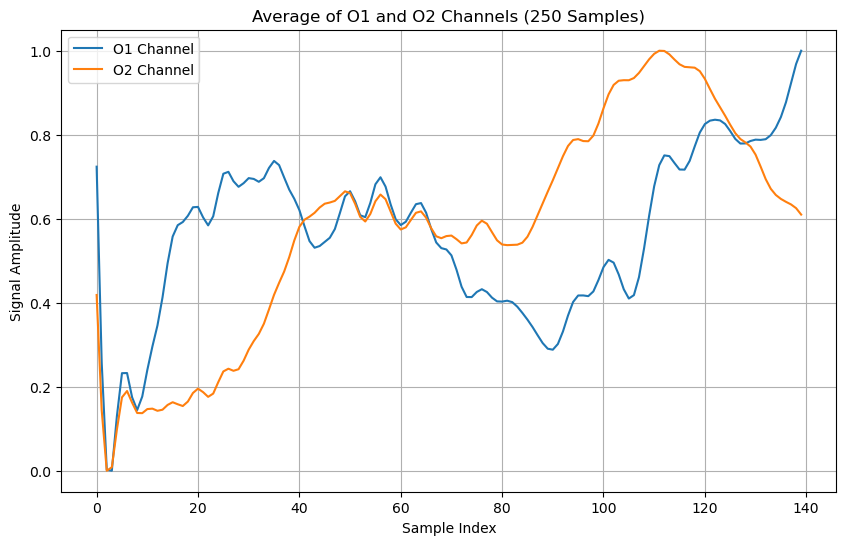

In [151]:
import matplotlib.pyplot as plt

# Plot the two channels
plt.figure(figsize=(10, 6))

# Plot the first channel (O1)
plt.plot(normalized_average_window[:, 0], label="O1 Channel")

# Plot the second channel (O2)
plt.plot(normalized_average_window[:, 1], label="O2 Channel")

# Add titles and labels
plt.title("Average of O1 and O2 Channels (250 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Signal Amplitude")
plt.legend()
plt.grid()

# Display the plot
plt.show()


# For all data windowinf and gettinh avg of windows

Processing for frequency: 0.0 Hz


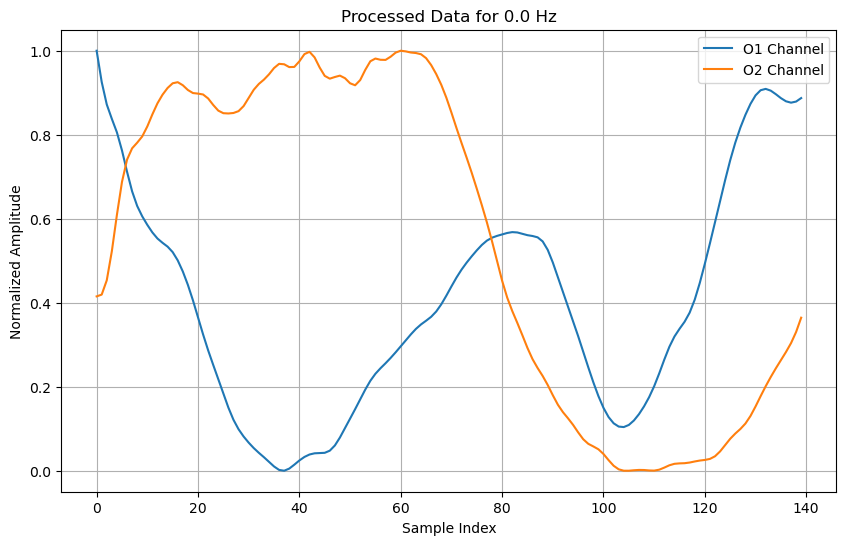

Processing for frequency: 1.7000335080035638 Hz


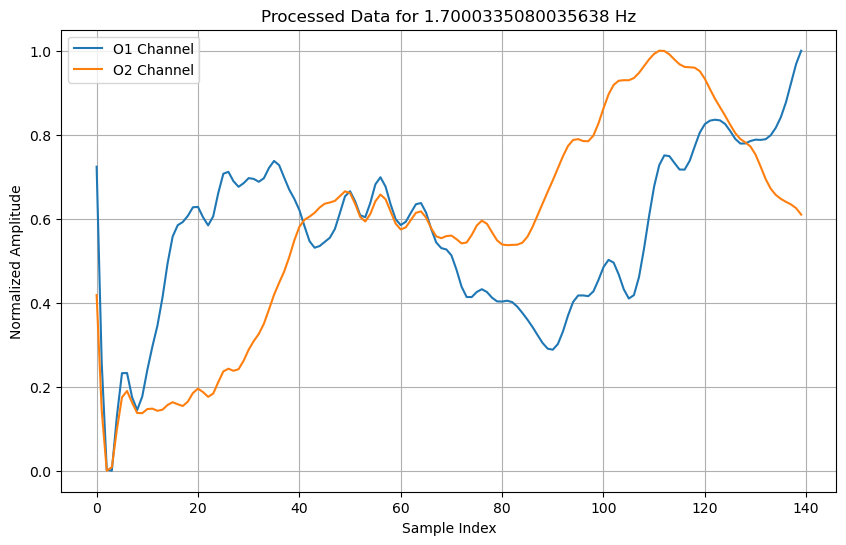

Processing for frequency: 3.7000029161356442 Hz


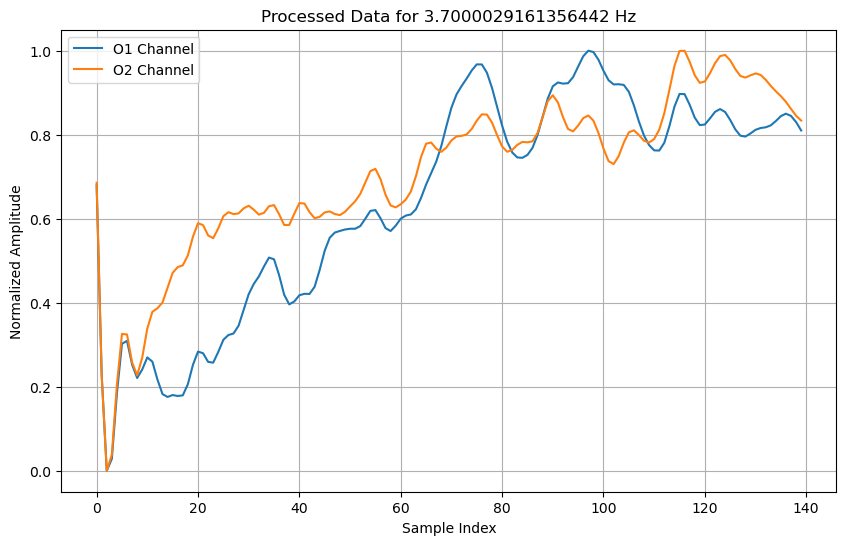

Processing for frequency: 5.199999809265137 Hz


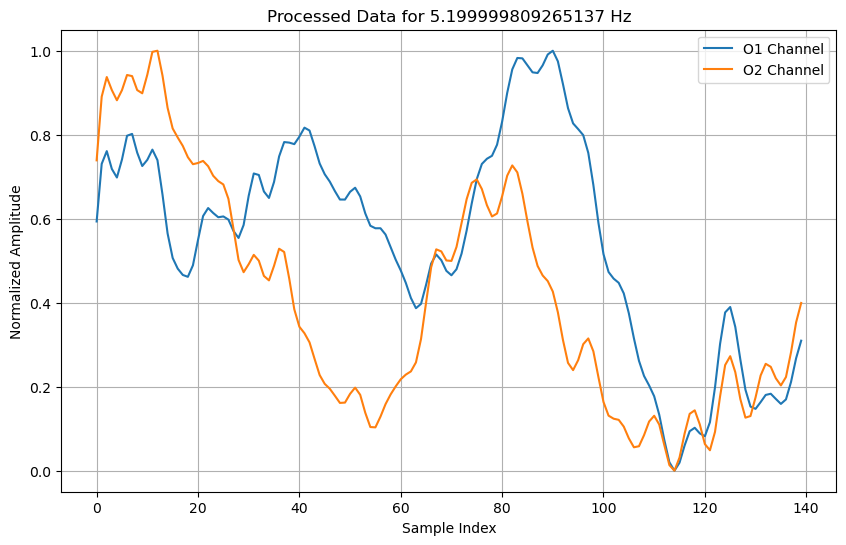

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch

# Define the filter function
def apply_filter(data, sampling_rate, cutoff, filter_type, order=4):
    nyquist = 0.5 * sampling_rate
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=filter_type, analog=False)
    return filtfilt(b, a, data, axis=0)

# Define the notch filter function
def apply_notch_filter(data, sampling_rate, notch_freq, quality_factor=30.0):
    nyquist = 0.5 * sampling_rate
    normalized_notch = notch_freq / nyquist
    b, a = iirnotch(normalized_notch, quality_factor)
    return filtfilt(b, a, data, axis=0)

# Normalize function: min-max normalization to scale between 0 and 1
def normalize_channel(channel):
    return (channel - np.min(channel)) / (np.max(channel) - np.min(channel))

# Function to process data for a given frequency
def process_frequency(signals, labels, target_label, sampling_rate=250, low_cutoff=1.0, high_cutoff=40.0, notch_freq=50.0, window_size=140):
    """
    Process signals for a specific target label (frequency).

    :param signals: The full signal array.
    :param labels: The corresponding labels.
    :param target_label: The target frequency label to process.
    :param sampling_rate: Sampling rate in Hz.
    :param low_cutoff: Low cutoff for bandpass filter.
    :param high_cutoff: High cutoff for bandpass filter.
    :param notch_freq: Notch filter frequency to remove.
    :param window_size: Window size for segmentation.
    :return: Processed and normalized average window for the target frequency.
    """
    # Extract indices for the target label
    labels_dict = {}
    for i, label in enumerate(labels):
        hashable_label = tuple(label) if isinstance(label, np.ndarray) else label
        if hashable_label not in labels_dict:
            labels_dict[hashable_label] = []
        labels_dict[hashable_label].append(i)

    if target_label not in labels_dict:
        print(f"Label {target_label} not found in the labels.")
        return None

    target_indices = labels_dict[target_label]
    target_signals = signals[target_indices, :]

    # Extract O1 and O2 channels
    o1_o2_channels = target_signals[:, 0:2]

    # Apply bandpass filter
    bandpass_filtered_data = apply_filter(o1_o2_channels, sampling_rate, [low_cutoff, high_cutoff], 'band')

    # Apply notch filter
    notch_filtered_data = apply_notch_filter(bandpass_filtered_data, sampling_rate, notch_freq)

    # Segment data into windows
    num_windows = notch_filtered_data.shape[0] // window_size
    windowed_data = notch_filtered_data[:num_windows * window_size].reshape(num_windows, window_size, 2)

    # Compute the average across all windows
    average_window = np.mean(windowed_data, axis=0)

    # Normalize the average window
    normalized_o1 = normalize_channel(average_window[:, 0])
    normalized_o2 = normalize_channel(average_window[:, 1])
    normalized_average_window = np.stack([normalized_o1, normalized_o2], axis=1)

    return normalized_average_window

# Function to plot processed data
def plot_processed_data(data, title="Processed Data for Target Frequency"):
    plt.figure(figsize=(10, 6))
    plt.plot(data[:, 0], label="O1 Channel")
    plt.plot(data[:, 1], label="O2 Channel")
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
def process_and_plot_for_frequencies(signals, labels, target_frequencies, **kwargs):
    for freq in target_frequencies:
        print(f"Processing for frequency: {freq} Hz")
        processed_data = process_frequency(signals, labels, (freq,), **kwargs)
        if processed_data is not None:
            plot_processed_data(processed_data, title=f"Processed Data for {freq} Hz")

# Example target frequencies


target_frequencies = [0.0,1.7000335080035638,3.7000029161356442,5.199999809265137]

# Call the function with signals, labels, and target frequencies
process_and_plot_for_frequencies(signals, labels, target_frequencies,
                                 sampling_rate=250,
                                 low_cutoff=1.0, 
                                 high_cutoff=40.0,
                                 notch_freq=50.0,
                                 window_size=140)



# Data processing anf classification


In [152]:
sampling_rate, lowcut, highcut = record.fs, 4, 30.0
print(sampling_rate)
o1_o2_channels = signals[:, 0:2]

processor = EMGProcessor(sampling_rate,lowcut=lowcut,highcut=highcut)
extractor = EMGFeatureExtractor(sampling_rate)

extractor.load_data(o1_o2_channels)
extractor.raw_data.shape


250


(19820, 2)

Filtered data shape: (19820, 1)
Created 141 windows of shape (140, 1)


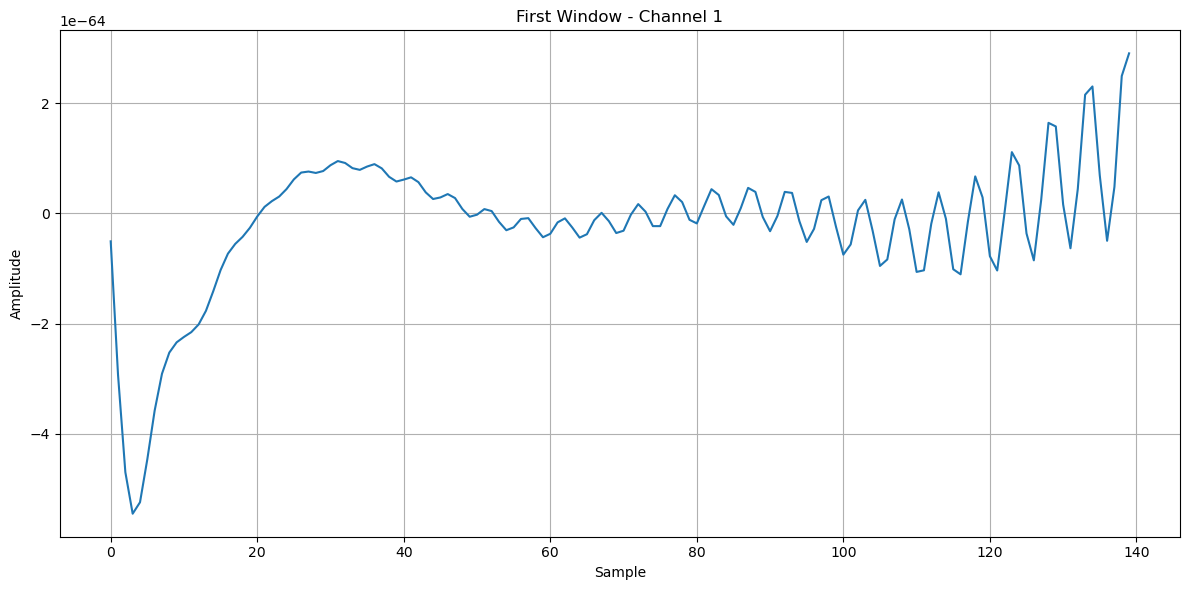

In [154]:
labels_processor = EMGProcessor(sampling_rate,lowcut=lowcut,highcut=highcut)
labels_extractor = EMGFeatureExtractor(sampling_rate)

labels_extractor.load_data(labels)
labels_extractor.filter_data(bandpass_filter=processor.bandpass_filter, notch_filter=processor.notch_filter)
labels_extractor.create_windows(window_size=140, overlap=0)
labels_extractor.plot_first_window()

Filtered data shape: (19820, 2)
Created 141 windows of shape (140, 2)


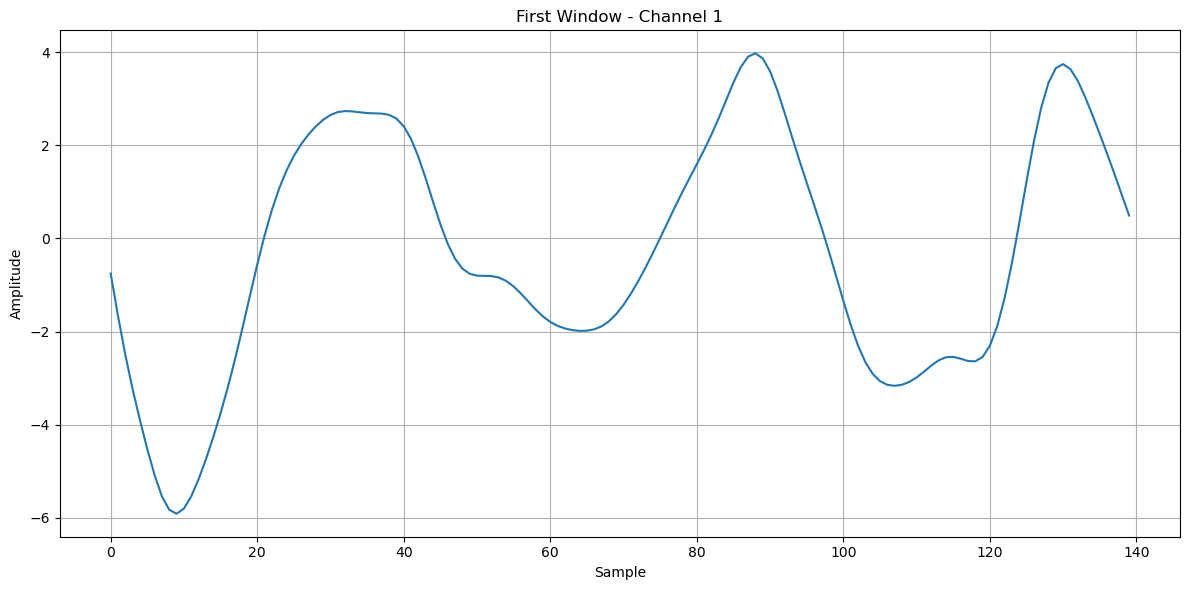

In [187]:
extractor.filter_data(bandpass_filter=processor.bandpass_filter, notch_filter=processor.notch_filter)
extractor.create_windows(window_size=140, overlap=0)
extractor.plot_first_window()



In [188]:
labels.shape

(19820, 1)

In [196]:
import numpy as np
from collections import Counter

def create_windowed_labels(labels, window_size=140):
    """
    Create new labels for windowed data by selecting the most repeated label in each window.

    :param labels: 1D or 2D array of original labels.
    :param window_size: Number of samples per window.
    :return: 1D array of new labels (one per window).
    """
    # Ensure labels are a numpy array
    labels = np.array(labels)

    # Convert labels to hashable types (e.g., tuple) if they are arrays
    if labels.ndim > 1:
        labels = [tuple(label) for label in labels]

    # Calculate the number of complete windows
    num_windows = len(labels) // window_size

    # Initialize a list to store new labels
    new_labels = []

    # Iterate over windows
    for i in range(num_windows):
        # Extract the labels for the current window
        window_labels = labels[i * window_size:(i + 1) * window_size]

        # Count occurrences of each label in the window
        label_counts = Counter(window_labels)

        # Get the most common label
        most_common_label = label_counts.most_common(1)[0][0]

        # Append the most common label to the new labels list
        new_labels.append(most_common_label)
   

    return np.array(new_labels)


window_size = 140

# Create new labels
new_labels = create_windowed_labels(labels, window_size).flatten()

# Print the results
print("New Labels for Windowed Data:")

print(new_labels.shape)


New Labels for Windowed Data:
(141,)


## Feature extraction

In [190]:

feature_names = [
        "Zero Crossing",
        "Waveform Length", 
        "Difference Absolute STD",
        "Integral Absolute Value",
        "Log Detector", 
        "Mean Absolute Value",
        "Root Mean Square",
        "Absolute Temporal Moment",
        "Variance",
        "V-Order",
        "Mean Frequency", 
        "Maximum Amplitude", 
        "Peak Frequency",
        "Mean Power",
        "Total Power", 
        "Variance of Central Frequency"
    ]

Feature extraction complete.
Features for the first window, first channel:
Zero Crossing: 5.0
Waveform Length: 41.94837704438086
Difference Absolute STD: 0.22824442439557519
Integral Absolute Value: 309.3729831503506
Log Detector: 1.7028718243546488
Mean Absolute Value: 2.2098070225025044
Root Mean Square: 2.5652453431739626
Absolute Temporal Moment: 6.5804836706757
Variance: 6.502493608427611
V-Order: 23.48750830078918
Mean Frequency: 9.366605406288617
Maximum Amplitude: 5.908723907459821
Peak Frequency: 5.357142857142857
Mean Power: 6.5804836706757
Total Power: 921.267713894598
Variance of Central Frequency: 186.5189839097319


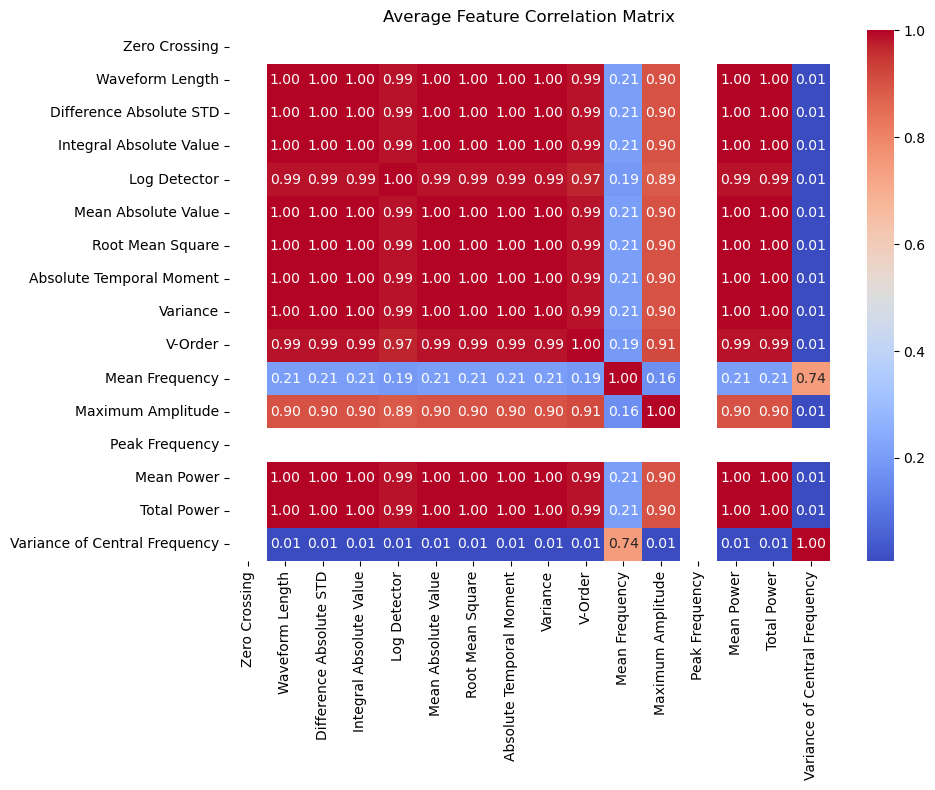

In [191]:
def extract_features_and_plot(extractor, feature_names, filename_prefix):
    features = extractor.extract_features()
    print(f"Features for the first window, first channel:")
    for i, name in enumerate(feature_names):
        print(f"{name}: {features[0, 0, i]}")

    correlation = extractor.compute_average_correlation(features)
    extractor.plot_correlation_matrix(correlation, feature_names=feature_names, filename=f"{filename_prefix}_correlation_matrix.png")
    return features, correlation

features,correlation = extract_features_and_plot(extractor, feature_names, "feature_extraction")



Removed 11 features. Retained 5 features.
Removed Features: {'Difference Absolute STD', 'Absolute Temporal Moment', 'Total Power', 'Log Detector', 'Maximum Amplitude', 'V-Order', 'Mean Power', 'Mean Absolute Value', 'Integral Absolute Value', 'Variance', 'Root Mean Square'}
Number of Retained Features: 5
Retained Features: ['Zero Crossing', 'Waveform Length', 'Mean Frequency', 'Peak Frequency', 'Variance of Central Frequency']


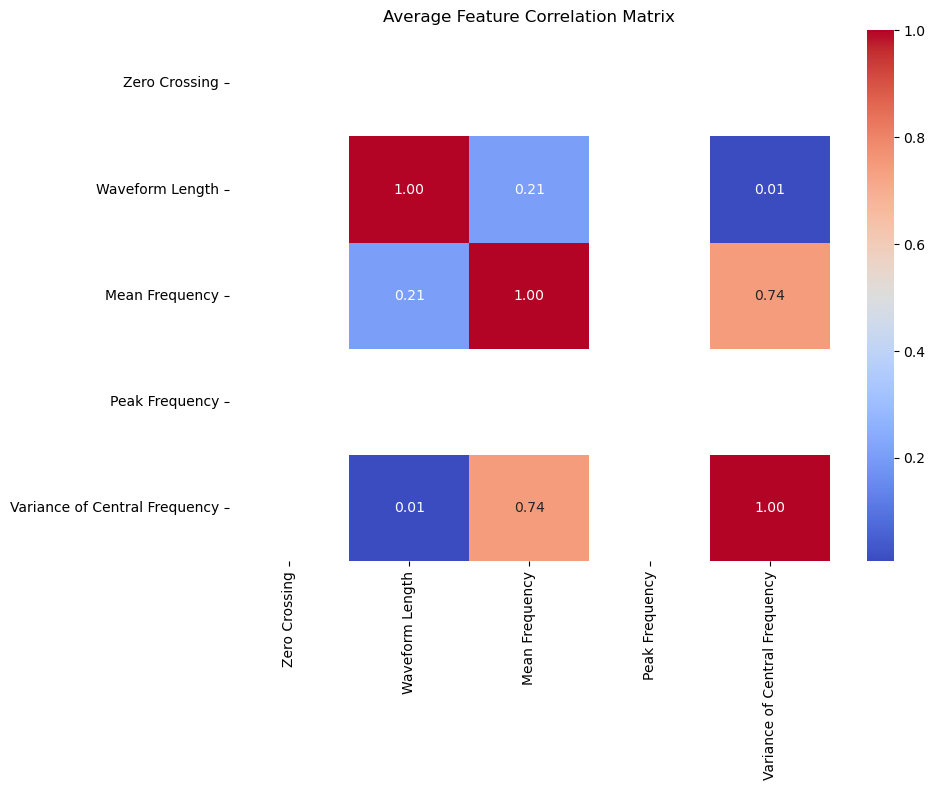

In [192]:

# Helper Functions
def remove_highly_correlated_features(extractor_concat, correlation_matrix, feature_names, threshold=0.9,filename="feature_extraction_reduced_correlation_matrix.png"):
    correlation_df = pd.DataFrame(correlation_matrix, columns=feature_names, index=feature_names)
    
    # Remove highly correlated features
    reduced_correlation_matrix, removed_features = extractor_concat.remove_highly_correlated_features(
        correlation_df, threshold=0.9
    )

    # Plot the reduced correlation matrix
    extractor_concat.plot_correlation_matrix(reduced_correlation_matrix, feature_names=reduced_correlation_matrix.columns)

    # Print summary
    print(f"Removed Features: {removed_features}")
    print(f"Number of Retained Features: {len(reduced_correlation_matrix.columns)}")
    
    # Ensure feature names are updated after removing redundant features
    retained_features = reduced_correlation_matrix.columns.tolist()
    print(f"Retained Features: {retained_features}")
    
     # Get the indices of retained features in the feature_names list
    retained_indices = [feature_names.index(feature) for feature in retained_features]


    return retained_features,retained_indices

# Remove highly correlated features
retained_features, retained_indices = remove_highly_correlated_features(extractor,correlation,feature_names)


In [193]:
# Prepare the feature matrix (filter to only retained features)
num_windows, num_channels, num_features = features.shape

# Reshape and reduce features for retained features
filtered_features = []
for ch in range(num_channels):
    # Convert features for this channel to a DataFrame
    X_df = pd.DataFrame(features[:, ch, :], columns=feature_names)
    # Select only the retained features
    X_reduced = X_df[retained_features].values
    filtered_features.append(X_reduced)
# Stack the features across channels
filtered_features = np.stack(filtered_features, axis=1)  # Shape: (num_windows, num_channels, num_retained_features)
filtered_features.shape

(141, 2, 5)

In [199]:
def discretize_labels(labels, num_bins=3):
    """
    Discretize continuous labels into discrete classes by binning.

    :param labels: Array of continuous labels.
    :param num_bins: Number of bins to categorize the labels.
    :return: Array of discrete labels.
    """
    bins = np.linspace(min(labels), max(labels), num_bins + 1)
    return np.digitize(labels, bins) - 1  # Bin indices start from 0

discrete_labels = discretize_labels(new_labels.flatten(), num_bins=4)

Processing Channel 1/2...
Processing Channel 2/2...
Feature Importances Across Channels:
                                                     Feature  Importance
Waveform Length                              Waveform Length    0.046512
Zero Crossing                                  Zero Crossing    0.034884
Peak Frequency                                Peak Frequency    0.018605
Mean Frequency                                Mean Frequency   -0.008140
Variance of Central Frequency  Variance of Central Frequency   -0.015116


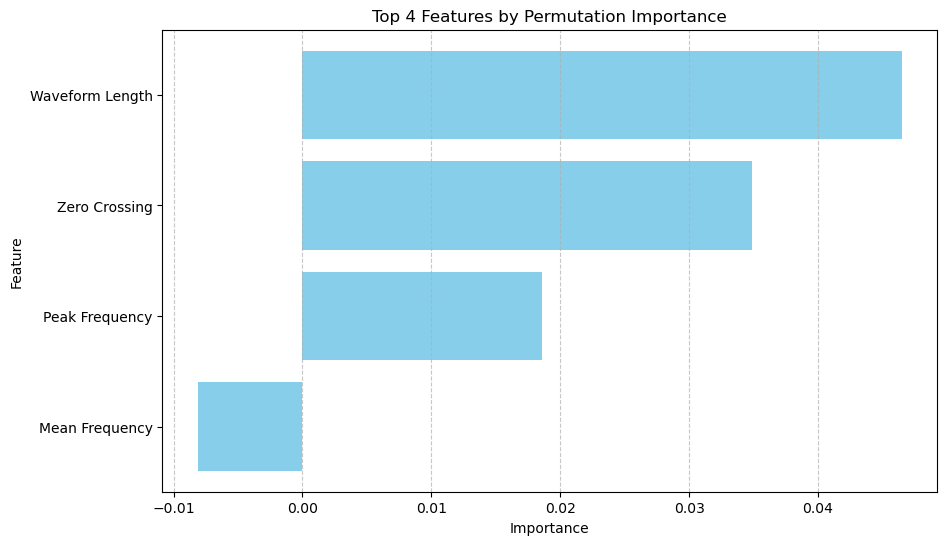

Saved feature importance plot as classification_task_top_4_features_importance.png
Top 4 Features:
                         Feature  Importance
Waveform Length  Waveform Length    0.046512
Zero Crossing      Zero Crossing    0.034884
Peak Frequency    Peak Frequency    0.018605
Mean Frequency    Mean Frequency   -0.008140


In [200]:

def compute_permutation_importance_per_channel(filtered_features, labels, feature_names, channels):
    # Initialize storage for channel-wise feature importances
    channel_importances = []

    # Iterate over each channel
    for ch in range(channels):
        print(f"Processing Channel {ch + 1}/{channels}...")

        # Extract features for the current channel
        X_channel = filtered_features[:, ch, :]  # Shape: (num_windows, num_retained_features)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X_channel, labels, test_size=0.3, random_state=42, stratify=labels)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train SVC model
        svc_model = SVC(kernel="rbf", random_state=42)
        svc_model.fit(X_train_scaled, y_train)

        # Compute permutation importance
        importance = permutation_importance(svc_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
        channel_importances.append(importance.importances_mean)  # Mean importance for each feature

    # Convert to a DataFrame
    feature_importances = pd.DataFrame(channel_importances, columns=feature_names)
    mean_importance = feature_importances.mean(axis=0)  # Mean across channels

    # Return DataFrame with mean importance
    return pd.DataFrame({"Feature": feature_names, "Importance": mean_importance}).sort_values(by="Importance", ascending=False)


def plot_feature_importances(feature_importances, top_n=4, filename="feature_importances.png"):

    # Select top-n features
    top_features = feature_importances.head(top_n)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Top {top_n} Features by Permutation Importance")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.savefig(filename)
    plt.show()

    print(f"Saved feature importance plot as {filename}")
    
 
# Compute feature importance across channels
feature_importances = compute_permutation_importance_per_channel(filtered_features, discrete_labels, retained_features, num_channels)

# Print top features
print("Feature Importances Across Channels:")
print(feature_importances)

# Plot and save the top 4 features
plot_feature_importances(feature_importances, top_n=4, filename="classification_task_top_4_features_importance.png")


# Save top features for further processing
top_4_features = feature_importances.head(4)
print("Top 4 Features:")
print(top_4_features)

Top 4 Features:
                         Feature  Importance
Waveform Length  Waveform Length    0.046512
Zero Crossing      Zero Crossing    0.034884
Peak Frequency    Peak Frequency    0.018605
Mean Frequency    Mean Frequency   -0.008140
SVM Accuracy: 0.40
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.20      0.27      0.23        11
           2       0.27      0.27      0.27        11
           4       0.71      0.45      0.56        11

    accuracy                           0.40        43
   macro avg       0.45      0.40      0.41        43
weighted avg       0.44      0.40      0.41        43

LDA Accuracy: 0.40
              precision    recall  f1-score   support

           0       0.75      0.30      0.43        10
           1       0.29      0.55      0.38        11
           2       0.33      0.36      0.35        11
           4       0.67      0.36      0.47        11

    accuracy  

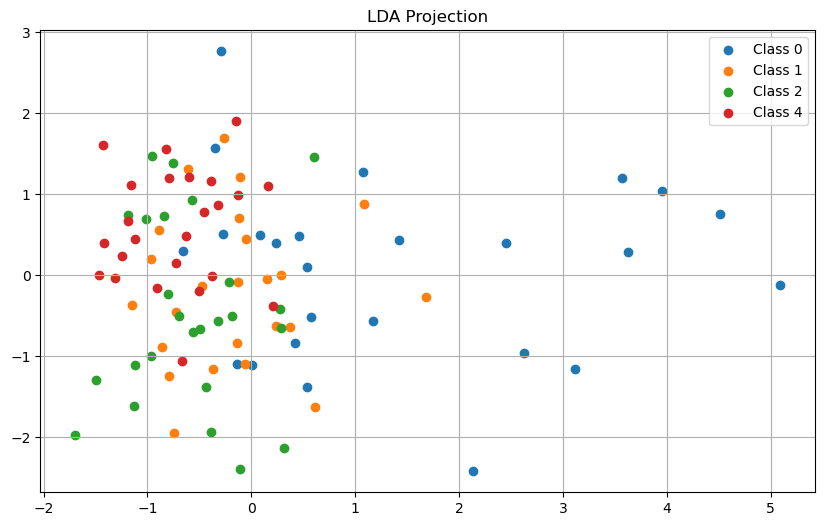

Random Forest Accuracy: 0.49
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.36      0.45      0.40        11
           2       0.31      0.36      0.33        11
           4       0.57      0.36      0.44        11

    accuracy                           0.49        43
   macro avg       0.53      0.50      0.50        43
weighted avg       0.52      0.49      0.50        43



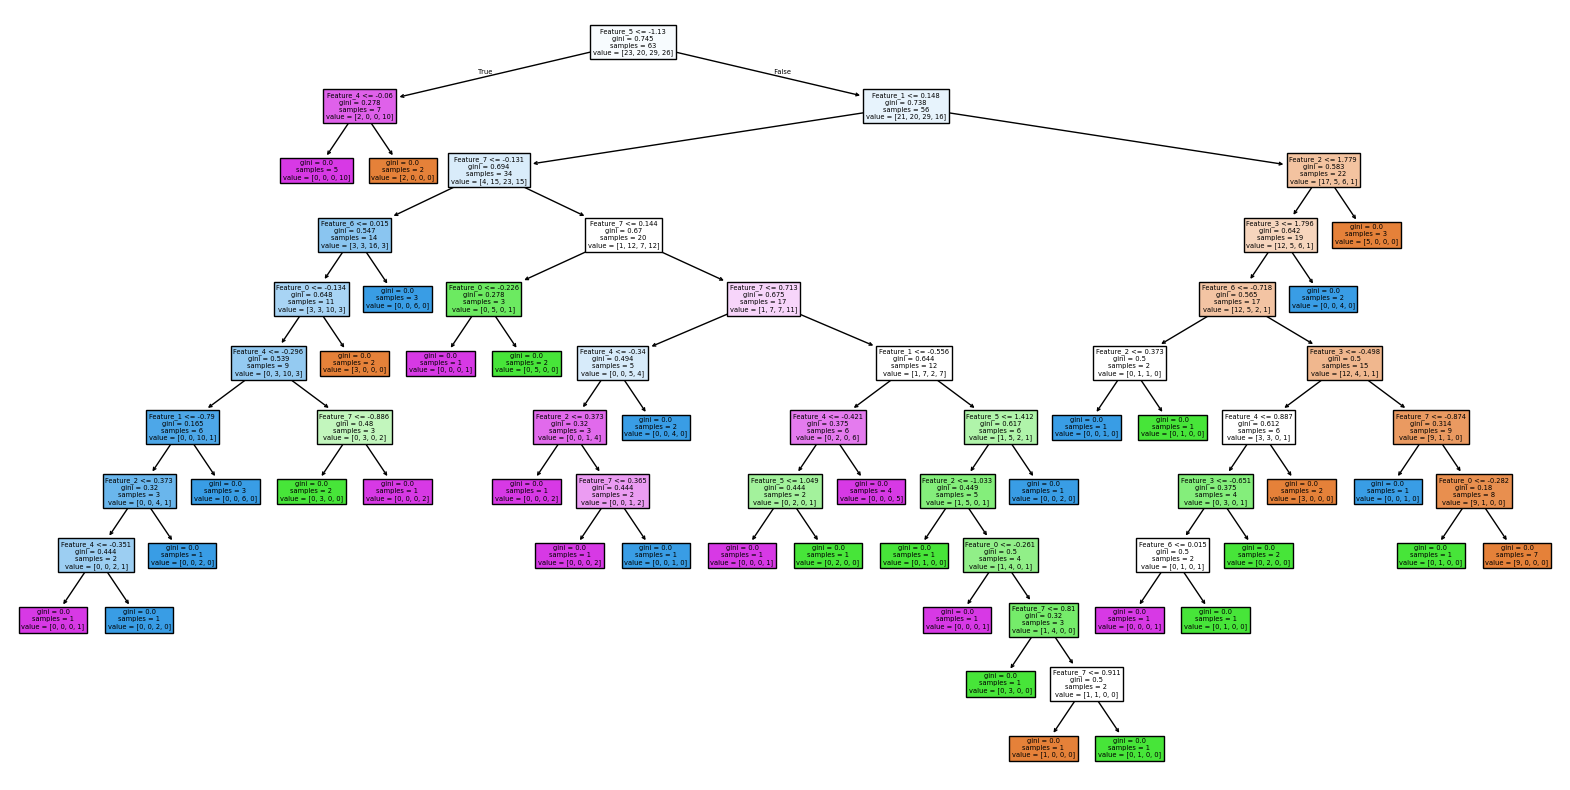

In [201]:

def train_and_evaluate_classification_model(X, y, filename_prefix):
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    
    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Support Vector Machine
    svc = SVC(kernel="rbf", random_state=42)
    svc.fit(X_train_scaled, y_train)
    y_pred_svc = svc.predict(X_test_scaled)
    print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svc):.2f}")
    print(classification_report(y_test, y_pred_svc))

    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_train_lda = lda.fit_transform(X_train_scaled, y_train)
    X_test_lda = lda.transform(X_test_scaled)
    
    # Fit and predict
    lda.fit(X_train_scaled, y_train)
    y_pred_lda = lda.predict(X_test_scaled)

    # Evaluate LDA
    accuracy_lda = accuracy_score(y_test, y_pred_lda)
    print(f"LDA Accuracy: {accuracy_lda:.2f}")
    print(classification_report(y_test, y_pred_lda))

    # Plot LDA Projection
    plt.figure(figsize=(10, 6))
    for label in np.unique(y_train):
        plt.scatter(X_train_lda[y_train == label, 0], X_train_lda[y_train == label, 1], label=f"Class {label}")
    plt.title("LDA Projection")
    plt.legend()
    plt.grid()
    plt.savefig(f"{filename_prefix}_lda_projection.png")
    plt.show()
    

    # Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    y_pred_rf = rf.predict(X_test_scaled)
    print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
    print(classification_report(y_test, y_pred_rf))

    # Plot a decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(rf.estimators_[0], feature_names=[f"Feature_{i}" for i in range(X_train_scaled.shape[1])], filled=True)
    plt.savefig(f"{filename_prefix}_decision_tree.png")
    plt.show()

# Save top features for further processing
top_4_features = feature_importances.head(4)
print("Top 4 Features:")
print(top_4_features)

new_top_4_features = feature_importances.head(4)["Feature"].tolist()

new_top_4_indices = [retained_features.index(feature) for feature in new_top_4_features]

    # Select the top features from the filtered features
filtered_training_features = filtered_features[:, :, new_top_4_indices]


training_features = filtered_training_features.reshape(num_windows, -1)

train_and_evaluate_classification_model(training_features, discrete_labels, "classification")